In [1]:
import torch
from torch import nn
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

In [15]:
rhs = lambda t, y: 2*t
 
class NNApproximator(nn.Module):
    """Simple neural network accepting one feature as input and returning a single output
    
    In the context of PINNs, the neural network is used as universal function approximator
    to approximate the solution of the differential equation
    """    
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh()):
        super().__init__()

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.layer_out(out)

def df(f: NNApproximator, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to the input feature(s) using PyTorch autograd engine"""
    df_value = f(x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value

def pinn_loss(f: NNApproximator, x_int: torch.tensor, x_bc: torch.tensor) -> torch.tensor:
    # DE contribution
    interior_loss = df(f, x_int) - rhs(x_int, None)

    # boundary contribution
    boundary_loss = f(x_bc) - 1.0

    final_loss = (interior_loss**2).mean() + boundary_loss ** 2
    return final_loss

In [20]:
# create model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NNApproximator(1,20)
print(model)

NNApproximator(
  (layer_in): Linear(in_features=1, out_features=20, bias=True)
  (layer_out): Linear(in_features=20, out_features=1, bias=True)
  (middle_layers): ModuleList()
  (act): Tanh()
)


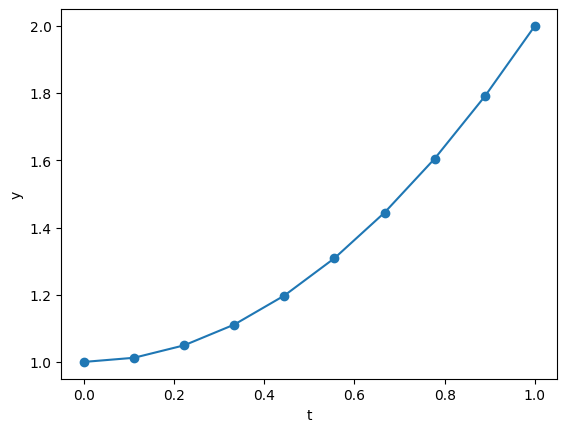

In [21]:
# prepare training data
# x = np.linspace(0,1,10)
sol = solve_ivp(rhs, t_span=[0,1], y0=[1.0], t_eval=np.linspace(0,1,10))
plt.plot(sol.t, sol.y[0,:], 'o-')
plt.xlabel("t")
plt.ylabel("y")

X_train = torch.tensor(sol.t, requires_grad=True).reshape(10,1)
Y_train = torch.tensor(sol.y[0,:],  requires_grad=True).reshape(10,1)

In [22]:
# train
epochs = 50000

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
model.train()

X_bc = X_train[0]
X_int = X_train[1:]
for epoch in range(epochs):
    pred = model(X_train)
    loss = pinn_loss(model, X_int, X_bc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % int(epochs/10) == 0:
        print(f"epoch={epoch}, loss={loss.item()}")

epoch=0, loss=1.9733727952640145
epoch=5000, loss=0.08327628843407513
epoch=10000, loss=0.0027409673270308113
epoch=15000, loss=0.0014383224186312249
epoch=20000, loss=0.0012394934326048653
epoch=25000, loss=0.001153145530669388
epoch=30000, loss=0.0010950157462990575
epoch=35000, loss=0.0010461040731338481
epoch=40000, loss=0.0010012235848646598
epoch=45000, loss=0.0009587822875053785


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

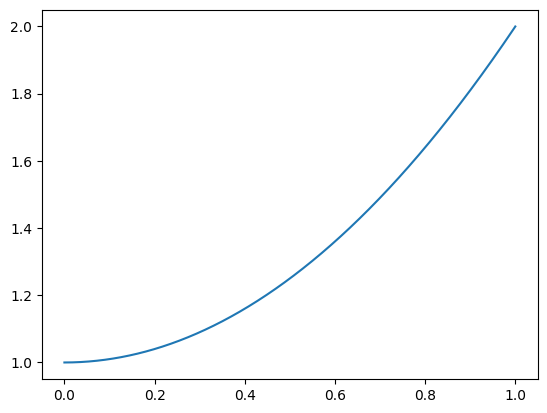

In [23]:
model.eval()

sol = solve_ivp(rhs, t_span=[0,1], y0=[1], t_eval=np.linspace(0,1,1000))
t, y = sol.t, sol.y[0,:]
plt.plot(t,y,label="analytical")
plt.plot(X_train.detach().numpy(), Y_train.detach().numpy(), 'o', label="training points")

y_pinn = model(torch.tensor(t).reshape(-1,1)).detach().numpy().flatten()
plt.plot(t, y_pinn, label="PINN")

plt.legend()